In [1]:
%reload_ext autoreload
%autoreload 2

In [12]:
import polars as pl 
from datetime import datetime
from statsmodels.graphics import tsaplots
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np 
import pandas as pd
import plotly.graph_objects as go 

from notebook_utils import insert_parent_in_path
insert_parent_in_path()

from src.paths import *
from src.logger import get_logger
from src.etl.dwh import run_database_operation
from src.config import TODAY_IS, TEST_DATA_FROM, TRAIN_DATA_FROM
from src.train import split_into_train_and_test
from src.plots import plot_ts, plot_relation_between_target_and_covariates
from src.pipeline import get_time_lags


sns.set()


logger = get_logger("dwh")

# Load from DWH

In [13]:
df = run_database_operation(
    operation="fetch_pickup_data",
    from_date=datetime(2023, 1, 1),
    to_date=datetime(2024,1,1),
    pickup_locations=[43]
)

# df = df.group_by_dynamic("pickup_datetime_hour", every="1d", by="pickup_location_id").agg(pl.col("num_pickup").sum())

2024-12-03 21:38:10,535 - src.etl.dwh - INFO - Running DB in mode CLOUD


In [14]:
df.head()

pickup_datetime_hour,pickup_location_id,num_pickup
date,i16,"decimal[38,0]"
2023-01-01,43,1129
2023-01-02,43,1283
2023-01-03,43,1474
2023-01-04,43,1464
2023-01-05,43,1859


In [5]:
# plotting functions work better with pandas
train_pd = train.to_pandas() 

# Plots

In [6]:
plot_ts(train_pd, "num_pickup")

- There seems to be a trend in 2021, showing demand recovering from COVID
- Daily and Monthly seasonal patterns

# Autocorrelation plot

C:\Users\selaf\AppData\Local\Temp\ipykernel_16132\3929085171.py:4: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



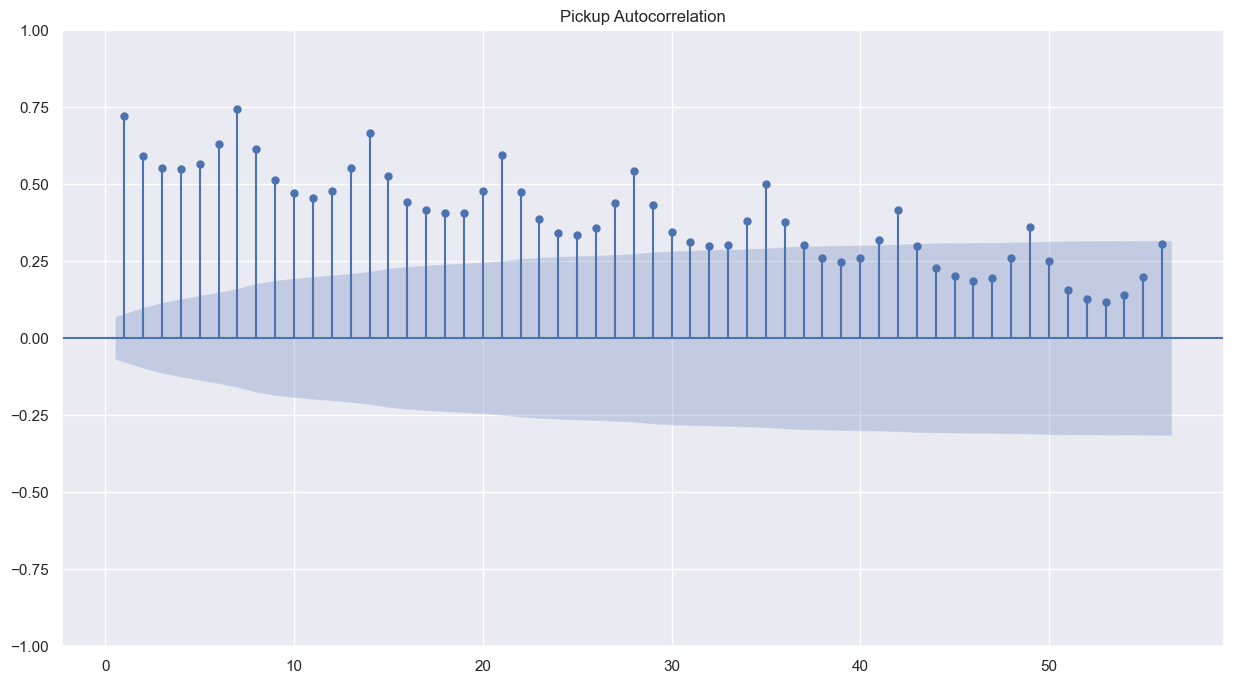

In [7]:
fig, ax = plt.subplots(1,1, figsize=(15,8))
tsaplots.plot_acf(train_pd.num_pickup, lags=56, ax=ax, zero=False)
ax.set_title("Pickup Autocorrelation")
fig.show()

In [8]:
import statsmodels.tsa.api as tsa

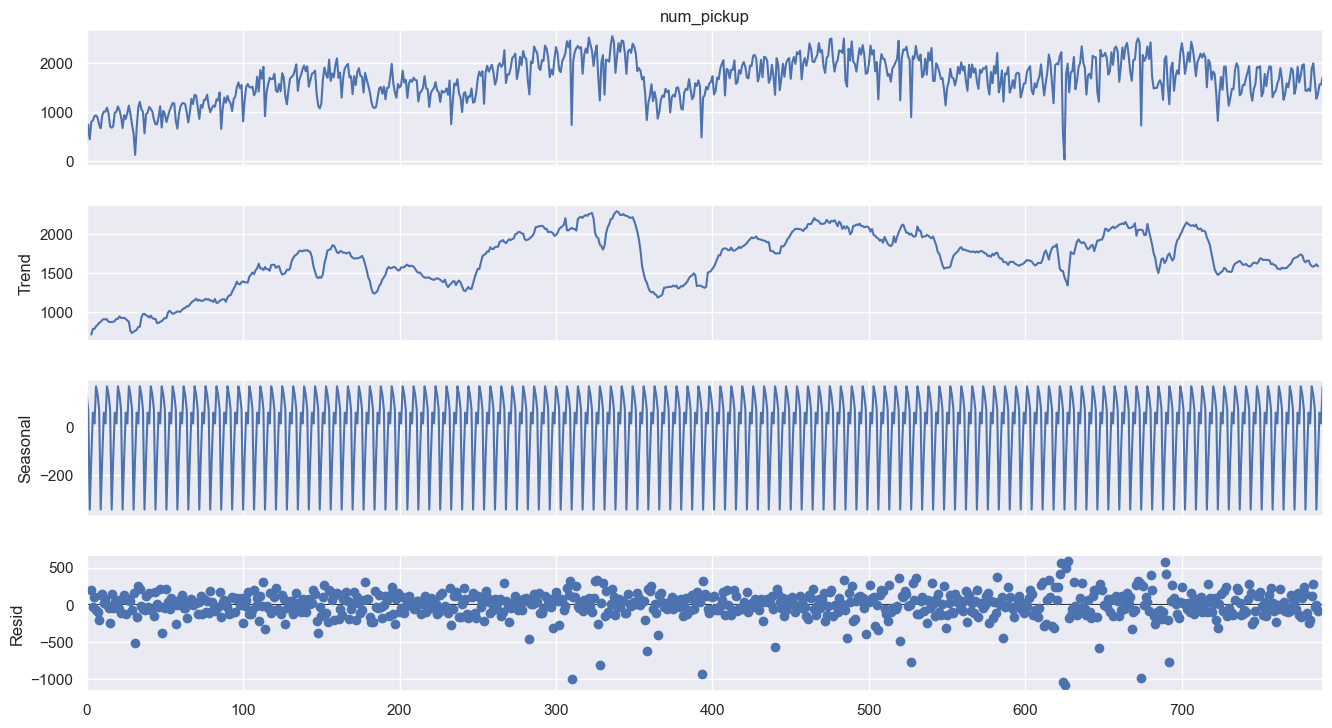

In [9]:
res = tsa.seasonal_decompose(train_pd.num_pickup, model="additive", period=7)
fig = res.plot()
fig.set_size_inches(15, 8)
plt.show()



In [10]:
train_with_lags = (
    train
    .pipe(get_time_lags, [1, 7, 14, 28])
)

train_with_lags_pd = train_with_lags.to_pandas()
train_with_lags_pd.head()


,pickup_datetime_hour,pickup_location_id,num_pickup,num_pickup_1d_ago,num_pickup_7d_ago,num_pickup_14d_ago,num_pickup_28d_ago
0,2021-01-29,43,960,1130,1037,972,378
1,2021-01-30,43,744,960,903,704,745
2,2021-01-31,43,561,744,671,677,439
3,2021-02-01,43,122,561,934,709,799
4,2021-02-02,43,675,122,856,989,827


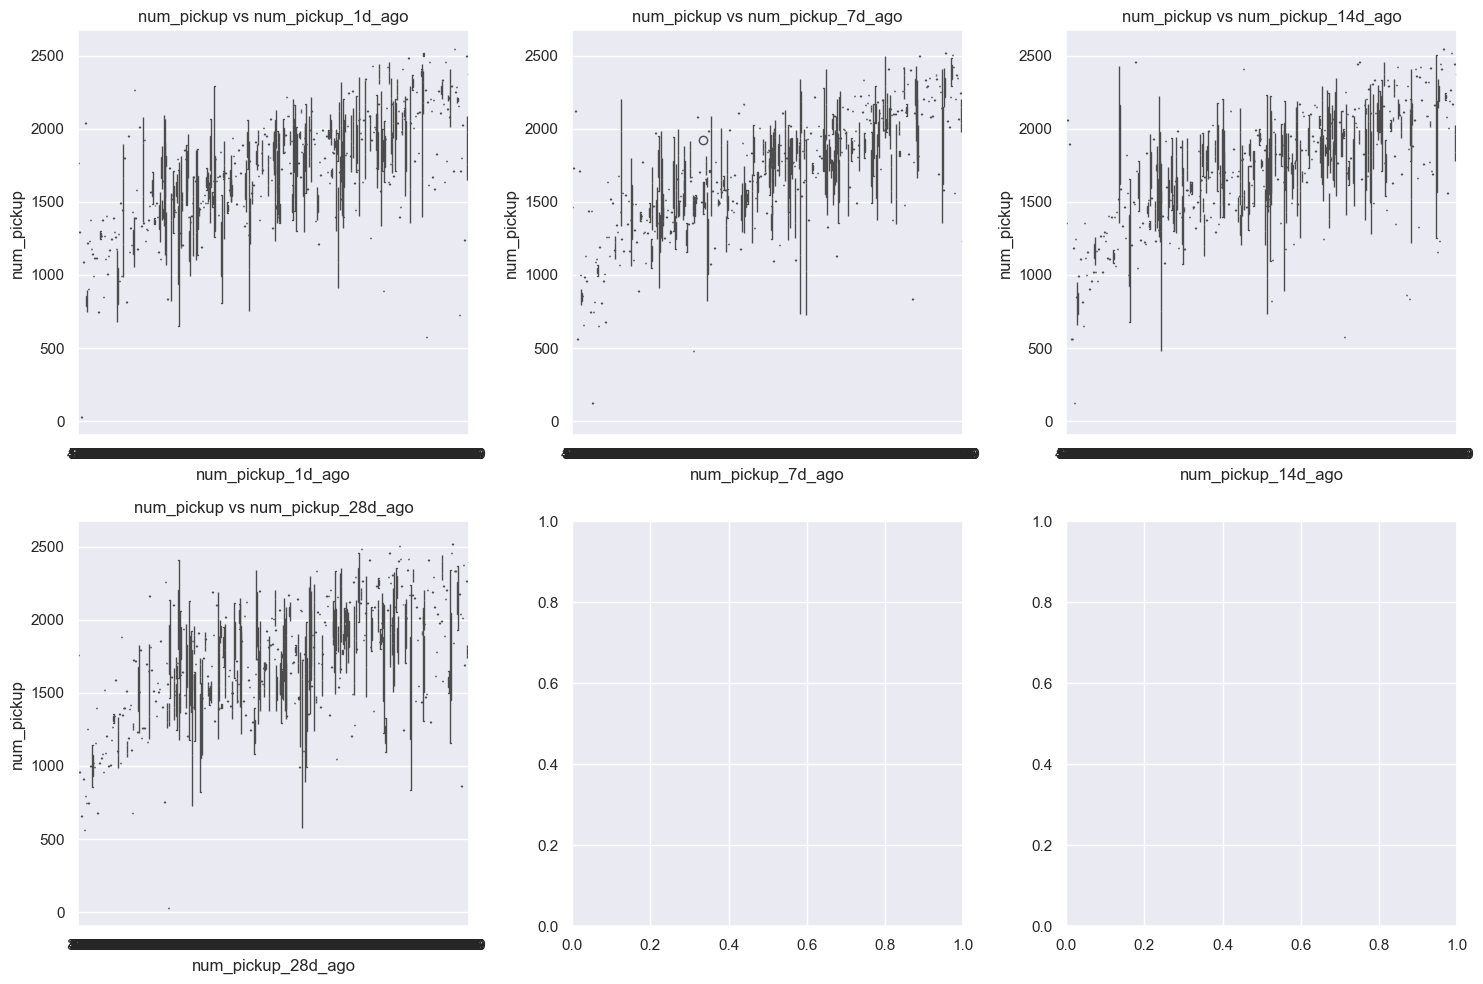

In [11]:
cols = ["num_pickup", "num_pickup_1d_ago", "num_pickup_7d_ago", "num_pickup_14d_ago", "num_pickup_28d_ago"]
plot_relation_between_target_and_covariates(
    data=train_with_lags.to_pandas()
    , target="num_pickup"
    , covariates=cols[1:]
)



# Conclusion

- There are strong autocorrelation patterns due to trend and seasonal components. A simple baseline model composed of the mean
of the past 1d, 7d, 14d and 28d can be a good start.